Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D vascular segmentation of the liver with UNET

1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/17PTo_MNNnzoSRfo0gtPVb1cWxIn2ez4W#scrollTo=DkSJDW4JCXWi)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB

## Setup imports

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import torch
from torch import nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.nn.modules import Module
import torch.nn._reduction as _Reduction
import matplotlib.pyplot as plt
import scipy
import tempfile
import shutil
from skimage.morphology import skeletonize, skeletonize_3d
import os
import glob

print_config()

MONAI version: 1.4.dev2412
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 66af634f24d71a71a281a3325a33df9418627320
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
root_dir = os.path.join("/content/drive/MyDrive/ProCom/")
print(root_dir)

/content/drive/MyDrive/ProCom/


## Set dataset path

In [5]:
images = sorted(glob.glob(os.path.join(root_dir, "Data/*VE.nii.gz")))
labels = sorted(glob.glob(os.path.join(root_dir, "Data/*VE-por.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(images, labels)]
train_files, val_files, test_files = data_dicts[:-6], data_dicts[-2:], data_dicts[-6:-2]
print(train_files, val_files)

[{'image': '/content/drive/MyDrive/ProCom/Data/01-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/01-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/02-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/02-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/03-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/03-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/04-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/04-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/05-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/05-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/06-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/06-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/07-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/07-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/08-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/08-VE-por.n

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

image shape: torch.Size([256, 256, 128]), label shape: torch.Size([256, 256, 128])


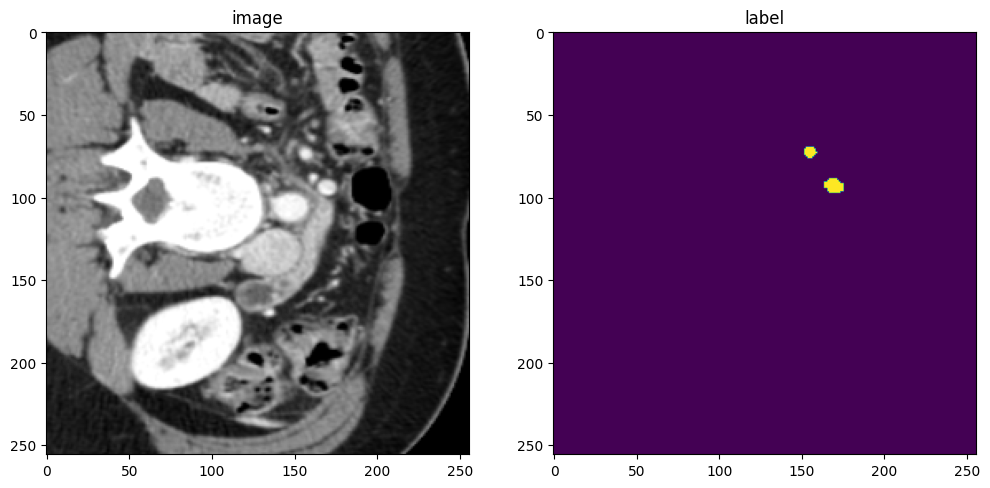

In [8]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 0])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid

## Create Model, Loss, Optimizer

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv3d(in_channels, out_channels//2, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm3d(out_channels//2),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels//2, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.conv(x)


In [11]:
class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[16, 32, 64, 128, 256]):
        super(UNET, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=1)

        # Down part of the UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of the UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='trilinear', align_corners=False)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [12]:
def cl_score(prediction, skeleton):
    #this function computes the skeleton volume overlap]
    return np.sum(prediction*skeleton)/np.sum(skeleton)


def clDice(prediction, mask):
    #this function computes the cldice metric]
    clDice_list = []
    for i in range(len(prediction)):
        prediction_image = prediction[i]
        mask_image = mask[i]
        if len(prediction_image.shape)==2:
            tprec = cl_score(prediction_image,skeletonize(mask_image))
            tsens = cl_score(mask_image,skeletonize(prediction_image))
        elif len(prediction_image.shape)==3:
            tprec = cl_score(prediction_image,skeletonize_3d(mask_image))
            tsens = cl_score(mask_image,skeletonize_3d(prediction_image))
        clDice_list.append(2*tprec*tsens/(tprec+tsens))
    return np.mean(clDice_list)

In [13]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = UNET(in_channels = 1, out_channels = 2).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [ ]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        metric_list = []
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                #dice_metric(y_pred=val_outputs, y=val_labels)
                metric_list.append(clDice(prediction=val_outputs[0].cpu().data.numpy(), mask=val_labels[0].cpu().data.numpy()))

            # aggregate the final mean dice result
            #metric = dice_metric.aggregate().item()
            metric = np.mean(metric_list)
            # reset the status for next validation round
            #dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_unet.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/7, train_loss: 0.4605
3/7, train_loss: 0.3984
4/7, train_loss: 0.4062
5/7, train_loss: 0.3735
6/7, train_loss: 0.4072
7/7, train_loss: 0.4108
epoch 147 average loss: 0.4086
----------
epoch 148/600
1/7, train_loss: 0.4087
2/7, train_loss: 0.4530
3/7, train_loss: 0.4105
4/7, train_loss: 0.3623
5/7, train_loss: 0.3793
6/7, train_loss: 0.4864
7/7, train_loss: 0.3514
epoch 148 average loss: 0.4074
current epoch: 148 current mean dice: 0.7407
best mean dice: 0.7829 at epoch: 82
----------
epoch 149/600
1/7, train_loss: 0.4003
2/7, train_loss: 0.4426
3/7, train_loss: 0.4471
4/7, train_loss: 0.3851
5/7, train_loss: 0.3501
6/7, train_loss: 0.4155
7/7, train_loss: 0.3682
epoch 149 average loss: 0.4013
----------
epoch 150/600
1/7, train_loss: 0.4006
2/7, train_loss: 0.4396
3/7, train_loss: 0.3499
4/7, train_loss: 0.4163
5/7, train_loss: 0.3840
6/7, train_loss: 0.4492
7/7, train_loss: 0.4130
epoch 150 average loss: 0

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8135 at epoch: 600


## Plot the loss and metric

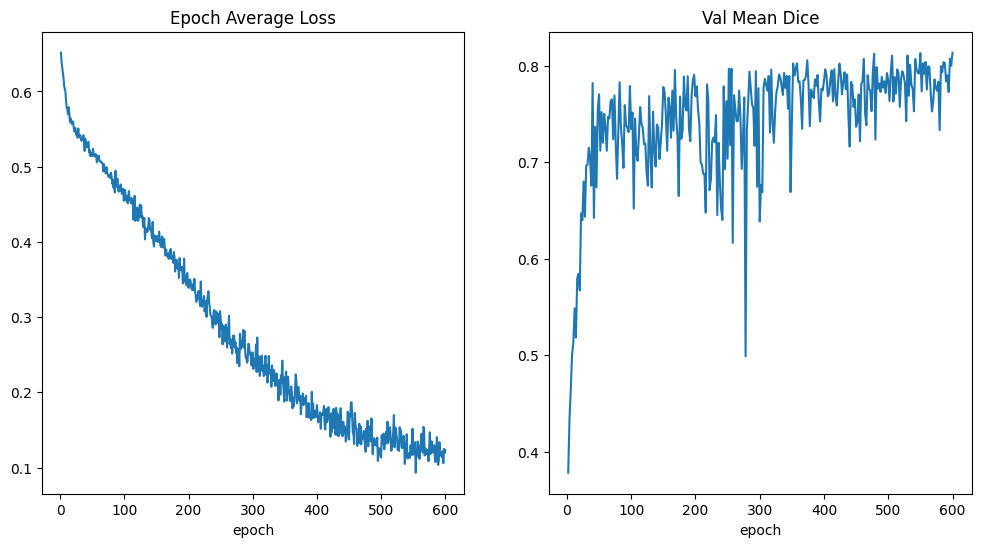

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

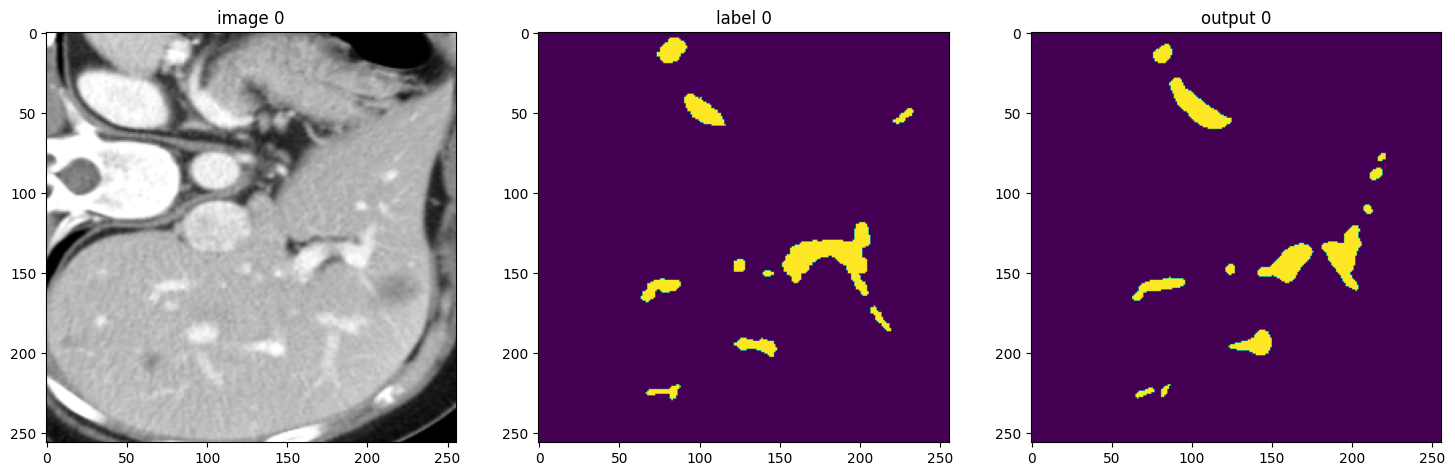

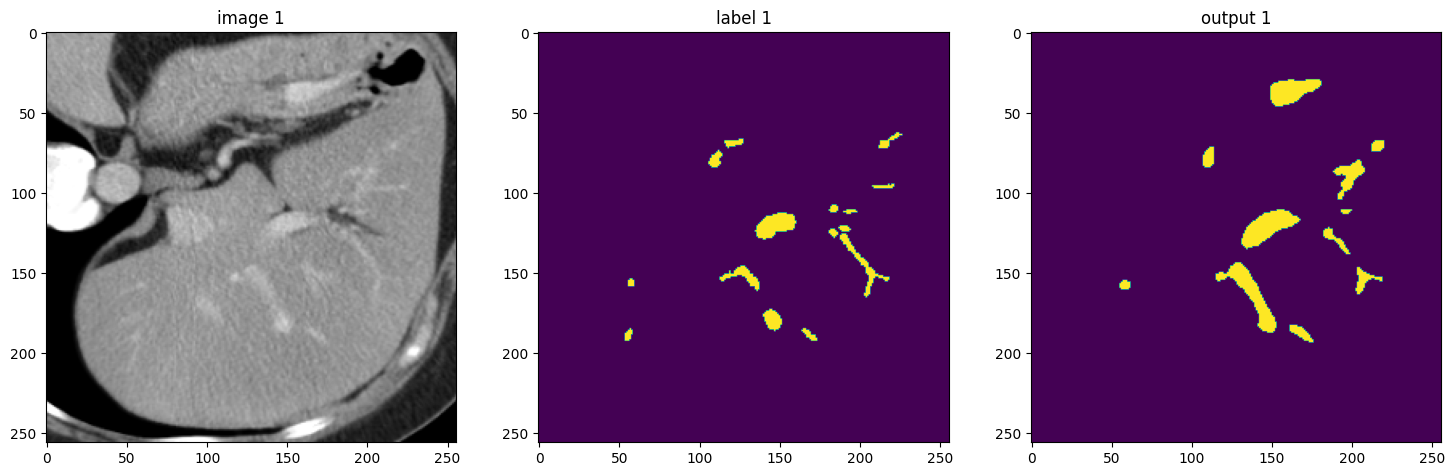

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_unet.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [14]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=test_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_unet.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.5851459503173828


## Inference on Test Set

In [15]:
test_org_ds = Dataset(data=test_files, transform=test_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [16]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

2024-03-28 11:46:47,720 INFO image_writer.py:197 - writing: out/15-VE/15-VE_seg.nii.gz


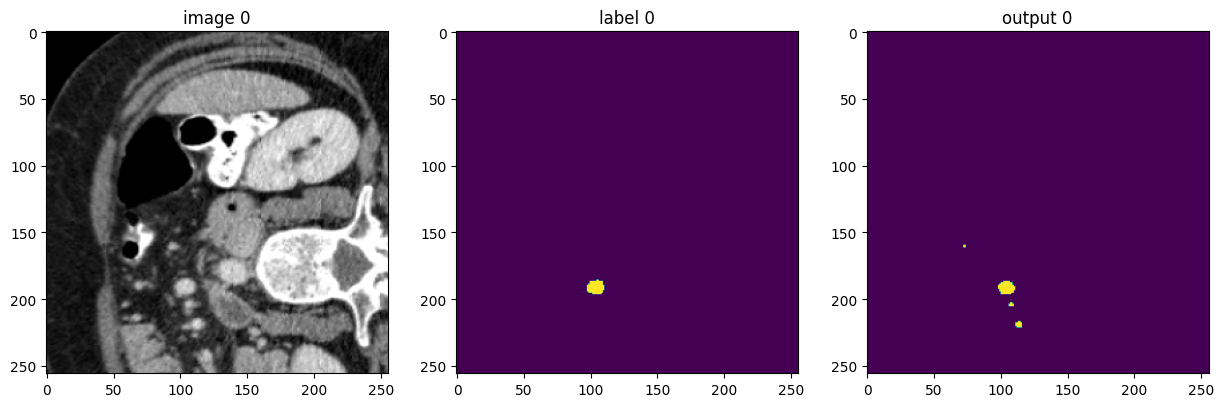

2024-03-28 11:47:18,775 INFO image_writer.py:197 - writing: out/16-VE/16-VE_seg.nii.gz


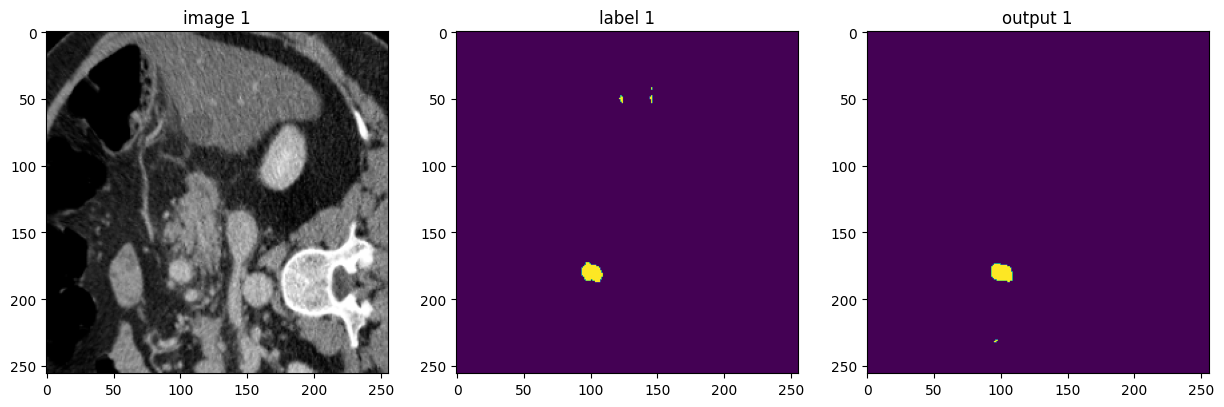

2024-03-28 11:47:42,423 INFO image_writer.py:197 - writing: out/17-VE/17-VE_seg.nii.gz


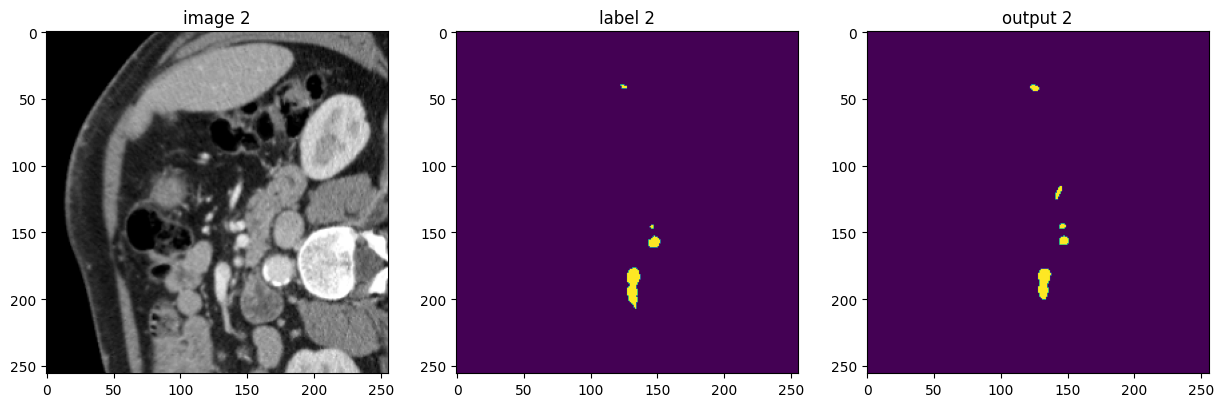

2024-03-28 11:48:08,687 INFO image_writer.py:197 - writing: out/18-VE/18-VE_seg.nii.gz


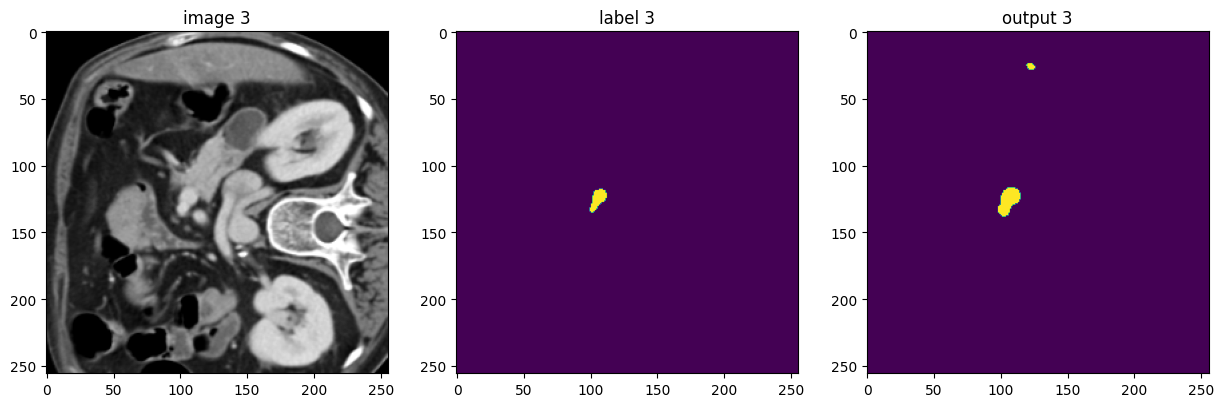

Dice Score on test images:  0.6482597589492798
clDice Score on test images:  0.8122773333419682


In [17]:
import nibabel

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_unet.pth"), map_location=torch.device('cpu')))
model.eval()
i=0
metric_list = []
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output, test_label = from_engine(["pred", "label"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])
        original_label = loader(test_label[0].meta["filename_or_obj"])

        plt.figure("Inference", (15, 20))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(original_label[:, :, 20])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()

        i+=1
        dice_metric(y_pred=test_output, y=test_label)
        metric_list.append(clDice(prediction=test_output[0].cpu().data.numpy(), mask=test_label[0].cpu().data.numpy()))


    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    metric = np.mean(metric_list)
    # reset the status for next validation round
    dice_metric.reset()

print("Dice Score on test images: ", metric_org)
print("clDice Score on test images: ", metric)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
#if directory is None:
   # shutil.rmtree(root_dir)